In [4]:
# Prelude
import ralphlib
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

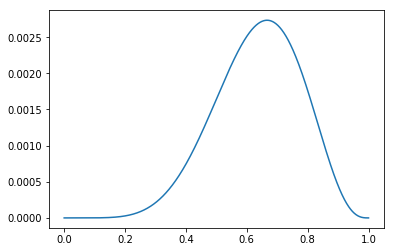

In [5]:
# 3E1
def world_toss_likelihood(num_water, num_tries):
    return lambda grid: stats.binom.pmf(num_water, num_tries, grid)

grid = np.linspace(start=0, stop=1, num=1000)
posterior = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(6, 9),
        grid
    ),
    index=grid
)
posterior.plot()

In [6]:
posterior[posterior.index >= 0.2].sum()

0.9991439048705782

(array([   46.,   512.,  2474.,  7166., 14071., 21202., 24298., 19667.,
         9282.,  1282.]),
 array([0.08908909, 0.17907908, 0.26906907, 0.35905906, 0.44904905,
        0.53903904, 0.62902903, 0.71901902, 0.80900901, 0.898999  ,
        0.98898899]),
 <a list of 10 Patch objects>)

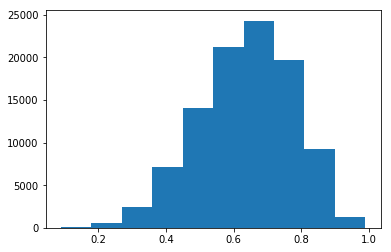

In [7]:
sample_size = 100000
sample = ralphlib.sample(posterior, sample_size)
plt.hist(sample)

In [8]:
param_values, counts = np.unique(sample, return_counts=True)
sample_freq = pd.Series(
    index=param_values,
    data=counts / sample_size
)

In [9]:
# 3E1
# Note: we are working with frequencies here! 
sample_freq[sample_freq.index < 0.2].sum()

0.0008699999999999999

In [10]:
# 3E2
sample_freq[sample_freq.index > 0.8].sum()

0.12092

In [11]:
# 3E3
sample_freq[(sample_freq.index > 0.2) & (sample_freq.index < 0.8)].sum()

0.8782099999999999

In [12]:
# 2E4
# Note: we are working directly with samples here!
# It's not easy (or possible? I think you need actual occurrence numbers and 
# not just frequency/probability?) to compute quantiles over frequencies/
# probabilities.
quantile0_2 = np.quantile(sample, 0.2)
quantile0_2

0.5165165165165165

In [13]:
sample_freq[sample_freq.index <= quantile0_2].sum()

0.20138000000000003

In [14]:
# 2E5
quantile0_8 = np.quantile(sample, 0.8)
quantile0_8

0.7607607607607607

In [15]:
sample_freq[sample_freq.index > quantile0_8].sum()

0.19963

In [16]:
# 3E6
def hdpi(sample, density):
    """Compute the highest density interval of the given density
    using the given samples from a distribution."""
    param_values, counts = np.unique(sample, return_counts=True)
    distribution = pd.Series(
        index=param_values,
        data=counts / len(sample)
    )
    
    distr_cumsum = distribution.cumsum()
    cumsum_density = distr_cumsum + density
    cumsum_density = cumsum_density[cumsum_density <= 1.0]
    # TODO do we need to finagle the np.quantile call to ensure it
    # only returns parameter values in the grid?
    q_series = cumsum_density.apply(lambda q: np.quantile(sample, q))
    
    fin_series = pd.Series(
        data=(q_series.values - q_series.index),
        index=q_series
    )
    
    fin_df = pd.DataFrame(
        data={
            "rhs": q_series.values,
            "width": q_series.values - q_series.index
        },
        index=q_series.index
    )
    
    # interval of given density with minimum width
    lhs = fin_df["width"].idxmin()
    return (lhs, fin_df["rhs"][lhs])

In [17]:
hpdi_interval = hdpi(sample, 0.66)

In [18]:
# 3E7
outside_half_density = (1-0.66)/2
eq_lhs = np.quantile(sample, outside_half_density)
eq_rhs = np.quantile(sample, 1 - outside_half_density)
symmetric_interval = (eq_lhs, eq_rhs)

In [19]:
# bonus: what is the value of p with maximal density?
sample_freq.idxmax()

0.6496496496496497

In [20]:
# bonus: widths of the two intervals
symmetric_width = symmetric_interval[1] - symmetric_interval[0]
hpdi_width = hpdi_interval[1] - hpdi_interval[0]
(symmetric_width, hpdi_width)

(0.27627627627627627, 0.2742742742742742)

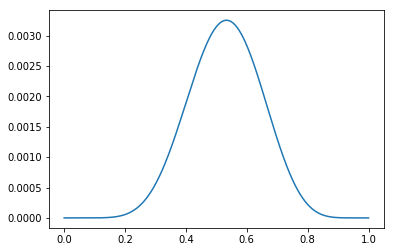

In [21]:
# 3M1
posterior2 = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(8, 15),
        grid
    ),
    index=grid
)
posterior2.plot()

In [22]:
# 3M2
sample2 = ralphlib.sample(posterior2, 10000)
hdpi(sample2, 0.9)

(0.33933933933933935, 0.7277277277277278)

(array([   6.,   38.,  115.,  252.,  528.,  820., 1164., 1399., 1463.,
        1392., 1137.,  873.,  493.,  223.,   97.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

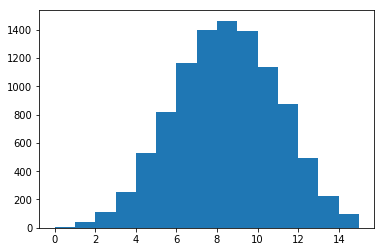

In [23]:
# 3M3
posterior_predictive_samples = np.vectorize(lambda p: np.random.binomial(15, p))(sample2)
plt.hist(posterior_predictive_samples, range(0, 16))

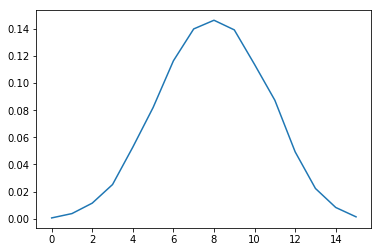

In [24]:
pp_vals, pp_counts = np.unique(posterior_predictive_samples, return_counts=True)
pp_distr = pd.Series(
    data=pp_counts / len(posterior_predictive_samples),
    index=pp_vals
)
pp_distr.plot()

In [25]:
pp_distr[8]

0.1463

In [26]:
# 3M4
posterior_predictive_samples_3m4 = np.vectorize(lambda p: np.random.binomial(9, p))(sample2)
pp_3m4_vals, pp_3m4_counts = np.unique(posterior_predictive_samples_3m4, return_counts=True)
pp_3m4_distr = pd.Series(
    data=(pp_3m4_counts / len(sample2)),
    index=pp_3m4_vals
)
pp_3m4_distr[6]

0.1728

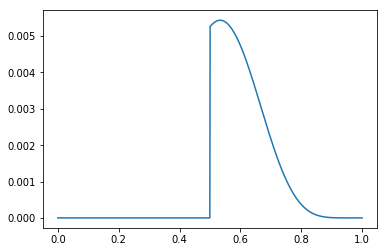

In [27]:
# 3M7
def nonuniform_prior(grid):
    gte0_5_prior = ralphlib.uniform_prior(grid[grid >= 0.5])
    gte0_5_prior *= 2
    lt0_5_prior = grid[grid < 0.5]
    lt0_5_prior.fill(0)
    return pd.Series(
        data=np.concatenate((lt0_5_prior, gte0_5_prior)),
        index=grid
    )

posterior_non_uniform = pd.Series(
    data=ralphlib.grid_approx(
        nonuniform_prior,
        world_toss_likelihood(8, 15),
        grid
    ),
    index=grid
)
posterior_non_uniform.plot()

(array([2.47936e+05, 2.34032e+05, 2.03443e+05, 1.46624e+05, 9.34770e+04,
        4.89270e+04, 1.91700e+04, 5.49600e+03, 8.41000e+02, 5.40000e+01]),
 array([0.5005005 , 0.54594595, 0.59139139, 0.63683684, 0.68228228,
        0.72772773, 0.77317317, 0.81861862, 0.86406406, 0.90950951,
        0.95495495]),
 <a list of 10 Patch objects>)

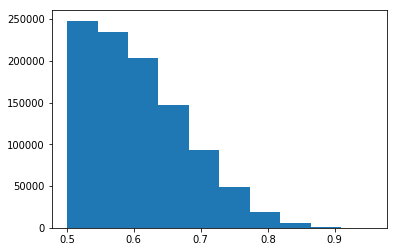

In [28]:
nonuniform_sample = ralphlib.sample(posterior_non_uniform, 1000000)
plt.hist(nonuniform_sample)

In [29]:
hdpi(nonuniform_sample, 0.9)

(0.5005005005005005, 0.7147147147147146)

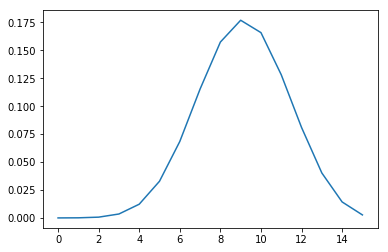

In [30]:
pp_sample = np.vectorize(lambda p: np.random.binomial(15, p))(nonuniform_sample)
pp_vals, pp_counts = np.unique(pp_sample, return_counts=True)
pp_distr = pd.Series(
    data=pp_counts / len(pp_sample),
    index = pp_vals
)
pp_distr.plot()

In [31]:
pp_distr[8]

0.15744

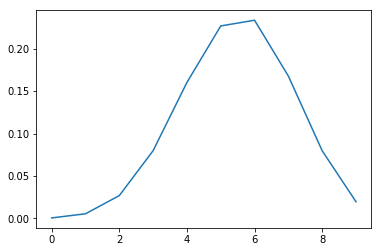

In [32]:
pp_sample9 = np.vectorize(lambda p: np.random.binomial(9, p))(nonuniform_sample)
pp_vals9, pp_counts9 = np.unique(pp_sample9, return_counts=True)
pp_distr9 = pd.Series(
    data=pp_counts9 / len(pp_sample9),
    index = pp_vals9
)
pp_distr9.plot()

In [33]:
pp_distr9[1]

0.005379

The prior shifted probability density in the posterior predictive check to the right -- to more water. In the posterior distribution over $p$ itself, the entire region below 0.5 is zeroed out. 

In [34]:
# Hard problem intro
birth1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0, 0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0, 1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])

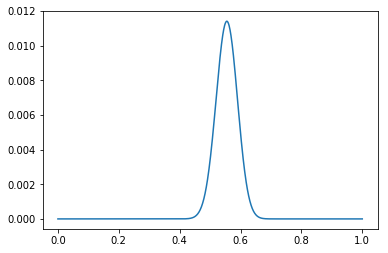

In [35]:
# 3H1
def births_likelihood(births):
    return lambda grid: stats.binom.pmf(sum(births), len(births), grid)

births_grid = np.linspace(start=0, stop=1, num=1000)
births_posterior = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        births_likelihood(np.concatenate((birth1, birth2))),
        births_grid
    ),
    index=births_grid
)
births_posterior.plot()

In [36]:
# maximum a posteriori estimate of p == probability of boy
births_map = births_posterior.idxmax()
births_map

0.5545545545545546

In [58]:
# 3H2
births_sample = ralphlib.sample(births_posterior, 10000)
[
    hdpi(births_sample, 0.5),
    hdpi(births_sample, 0.89),
    hdpi(births_sample, 0.97)
]

[(0.5255255255255256, 0.5735735735735735),
 (0.4954954954954955, 0.6076076076076076),
 (0.4744744744744745, 0.6256256256256256)]

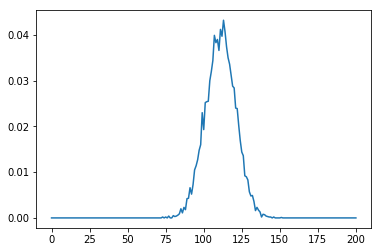

In [38]:
gen_births_pp_sample = np.vectorize(lambda p: np.random.binomial(len(birth1) + len(birth2), p))
births_pp_sample = gen_births_pp_sample(births_sample)
births_pp_freq = ralphlib.normalize(births_pp_sample, range(0, len(birth1) + len(birth2) + 1))
births_pp_freq.plot()

In [51]:
(sum(birth1) + sum(birth2), hdpi(births_pp_sample, 0.3))

(111, (104, 112.0))

In [43]:
births_pp_freq[sum(birth1) + sum(birth2)]

0.0412

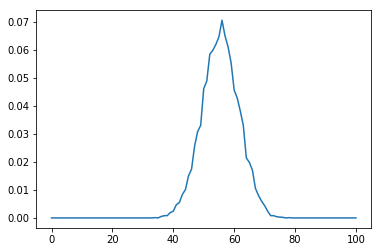

In [63]:
# 3H4
gen_births_first_pp_sample = np.vectorize(lambda p: np.random.binomial(len(birth1), p))
births_first_pp_sample = gen_births_first_pp_sample(births_sample)
births_first_pp_freq = ralphlib.normalize(births_first_pp_sample, range(0, len(birth1) + 1))
births_first_pp_freq.plot()

In [67]:
# simulating 100 births, birth1 has slightly more probability density
# when comparing to the analysis with the sum of births.
births_first_pp_freq[sum(birth1)]

0.0488

In [70]:
# 3H5
